# Common data exploration on preferences

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
import plotly.express as px
import plotly
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose, STL
import networkx as nx
from scipy.stats import f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd

sns.set_theme()

In [2]:
df_rb_beers     = pd.read_csv('../../data/rate_beer/beers.csv')
df_rb_breweries = pd.read_csv('../../data/rate_beer/breweries.csv')
df_rb_users     = pd.read_csv('../../data/rate_beer/users.csv')
df_rb_ratings   = pd.read_csv('../../data/rate_beer/ratings.csv')

In [3]:
df_rb_ratings['day']     = pd.to_datetime(df_rb_ratings['date'], unit='s').dt.to_period('D')
df_rb_ratings['week']    = pd.to_datetime(df_rb_ratings['date'], unit='s').dt.to_period('W').dt.start_time
df_rb_ratings['month']   = pd.to_datetime(df_rb_ratings['date'], unit='s').dt.to_period('M').dt.start_time
df_rb_ratings['quarter'] = pd.to_datetime(df_rb_ratings['date'], unit='s').dt.to_period('Q')
df_rb_ratings['year']    = pd.to_datetime(df_rb_ratings['date'], unit='s').dt.to_period('Y')

## Pre-processing

In [4]:
def compute_cumulative_ratings_count(dataframe: pd.DataFrame):
    dataframe = dataframe.sort_values(['date'])
    dataframe['_count'] = 1
    dataframe['cumulative_ratings_count'] = dataframe['_count'].cumsum()
    dataframe = dataframe.drop(columns=['_count'])
    return dataframe

<Axes: title={'center': 'Cumulative ratings count'}, xlabel='month', ylabel='Cumulative ratings count'>

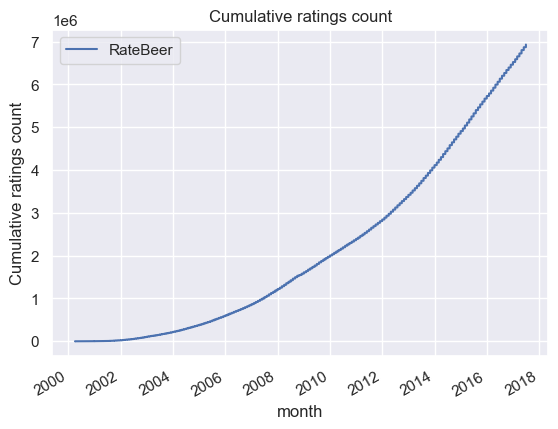

In [5]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
plt.title('Cumulative ratings count')
plt.xlabel('Month')
plt.ylabel('Cumulative ratings count')
compute_cumulative_ratings_count(df_rb_ratings).plot(x='month', y='cumulative_ratings_count', label='RateBeer', ax=ax)

In [6]:
def remove_before_month(dataframe: pd.DataFrame, month: str = '2004-01') -> pd.DataFrame:
    dataframe = dataframe.sort_values(['user_id', 'date'])
    dataframe = dataframe.merge(
        (dataframe.groupby('user_id')['month'].first() >= month).reset_index().rename(columns={'month': 'is_first_rating_after_month'}),
        on='user_id'
    )
    dataframe = dataframe[dataframe['is_first_rating_after_month']]
    dataframe = dataframe.drop(columns=['is_first_rating_after_month'])
    return dataframe

In [7]:
df_rb_ratings = remove_before_month(df_rb_ratings, '2004-01')

## Begginning of analysis

In [10]:
df_rb_users.head()

,user_id,user_ratings_count,user_name,user_created_date,user_country,user_region,user_country_code
0,2,52,wade,955533600.0,United States,Georgia,USA
1,3,219,billb,955533600.0,United States,Georgia,USA
2,7,42,young,955533600.0,United States,Georgia,USA
3,10,5,Mark99,955533600.0,United States,Georgia,USA
4,15,1,lazarus99,955533600.0,United States,Georgia,USA


In [11]:
df_rb_ratings.head()

,user_id,beer_id,brewery_id,date,rating,overall,aroma,appearance,palate,taste,...,beer_past_ratings_average,beer_global_style,user_beer_style_past_ratings_count,user_beer_style_past_ratings_average,gini_impurity,day,week,month,quarter,year
46330,379,23339,1076,1089626400,4.2,4.50,4.0,5.0,4.0,3.5,...,3.166667,Dark Lager,1,4.200000,1.071429,2004-07-12,2004-07-12,2004-07-01,2004Q3,2004
46331,379,2917,511,1089712800,2.7,2.75,2.5,3.0,3.0,2.5,...,2.294836,Pale Lager,1,2.700000,0.000000,2004-07-13,2004-07-12,2004-07-01,2004Q3,2004
46332,379,3922,672,1089712800,2.6,2.50,2.5,2.0,3.0,3.0,...,2.212088,Pale Lager,2,2.650000,0.535714,2004-07-13,2004-07-12,2004-07-01,2004Q3,2004
46333,379,401652,2213,1089712800,1.9,1.50,2.0,3.0,2.0,2.0,...,2.075000,Dark Lager,2,3.050000,0.476190,2004-07-13,2004-07-12,2004-07-01,2004Q3,2004
46334,379,18483,3097,1089799200,2.1,1.50,3.0,3.0,2.0,2.0,...,2.950000,Pale Lager,3,2.466667,0.535714,2004-07-14,2004-07-12,2004-07-01,2004Q3,2004
